# Colab Setting
------

execute only one (save to google drive) or save to colabs

Save to Google Drive(could be accessed later)

In [ ]:
#from google.colab import drive
#drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#% cd /content/gdrive/My Drive/
#! git clone https://github.com/DSC-UI-SRIN/Introduction-to-GAN.git
#% cd /content/gdrive/My Drive/Introduction-to-GAN/4 - Applications of GANs/melgan
#! pip install -r requirements.txt

Save to Colabs (deleted if colabs reset)

In [1]:
! git clone https://github.com/DSC-UI-SRIN/Introduction-to-GAN.git
% cd /content/Introduction-to-GAN/4 - Applications of GANs/melgan
! pip install -r requirements.txt
! pip install librosa==0.7

fatal: destination path 'Introduction-to-GAN' already exists and is not an empty directory.
/content/Introduction-to-GAN/4 - Applications of GANs/melgan


In [1]:
%ls

/content/Introduction-to-GAN/4 - Applications of GANs/melgan
assets/      inference.ipynb       LJSpeech-1.1.tar.bz2.1  temp-restore.yaml
colab.ipynb  inference.py          model/                  trainer.py
config/      LICENSE               preprocess.py           utils/
datasets/    LJSpeech-1.1/         README.md
hubconf.py   LJSpeech-1.1.tar.bz2  requirements.txt


In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar xvjf LJSpeech-1.1.tar.bz2

## Why Melgan ? 
mel to wav without deep learning example

In [2]:
import numpy
import librosa
import soundfile

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

# plot function
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), squeeze=False, figsize=figsize)
    for i in range(len(data)):
        axes[0,i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
        
# parameters
sr = 22050
n_mels = 128
hop_length = 512
n_iter = 32
n_mfcc = None # can try n_mfcc=20

# load audio and create Mel-spectrogram
path = "./assets/LJ001-0005.wav"
y, _ = librosa.load(path, sr=sr)
S = numpy.abs(librosa.stft(y, hop_length=hop_length, n_fft=hop_length*2))
mel_spec = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels, hop_length=hop_length)

In [3]:
#original
ipd.Audio(y, rate=sr)

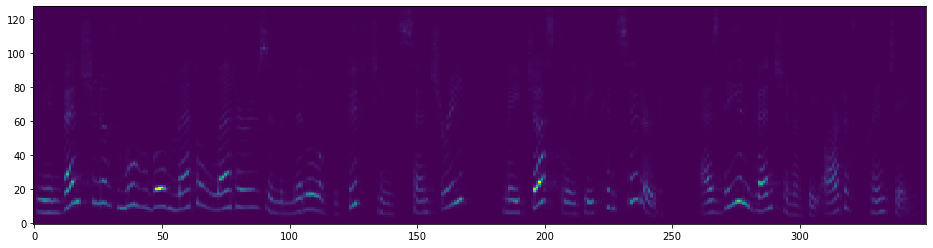

In [6]:
plot_data([mel_spec])

In [7]:
# optional, compute MFCCs in addition
if n_mfcc is not None:
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), sr=sr, n_mfcc=n_mfcc)
    mel_spec = librosa.feature.inverse.mfcc_to_mel(mfcc, n_mels=n_mels)

# Invert mel-spectrogram
S_inv = librosa.feature.inverse.mel_to_stft(mel_spec, sr=sr, n_fft=hop_length*4)
y_inv = librosa.griffinlim(S_inv, n_iter=n_iter,
                            hop_length=hop_length)

#inversed
ipd.Audio(y_inv, rate=sr)

mel to audio could lose data during conversion process

# Text to Speech - Demo
---------------

![Image of Yaktocat](https://www.researchgate.net/profile/Dharmesh_Agrawal/publication/320733074/figure/fig1/AS:559863667609600@1510493308439/Block-diagram-of-Mel-spectrogram-of-an-audio-signal-After-2.png)

![Mel](https://haythamfayek.com/assets/posts/post1/filter_banks_raw.jpg)

In [4]:
import os
import glob
import tqdm
import torch
import argparse
from scipy.io.wavfile import write

from model.generator import Generator
from utils.hparams import HParam, load_hparam_str
from utils.stft import TacotronSTFT
from utils.utils import read_wav_np

import IPython.display as ipd

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

In [5]:
# load model
checkpoint = torch.load("./assets/model.pt")
hp = HParam("./config/default.yaml")

model = Generator(hp.audio.n_mel_channels).cuda()
model.load_state_dict(checkpoint['model_g'])
model.eval(inference=True)

In [6]:
# plot function
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), squeeze=False, figsize=figsize)
    for i in range(len(data)):
        axes[0,i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
        
def powerToDB(x):
    amin = 1e-10
    ref_val = np.max(x)
    magnitude = np.abs(x)
    top_db = 80.0
    
    log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref_val))
    log_spec = np.maximum(log_spec, log_spec.max() - top_db)
    
    return log_spec

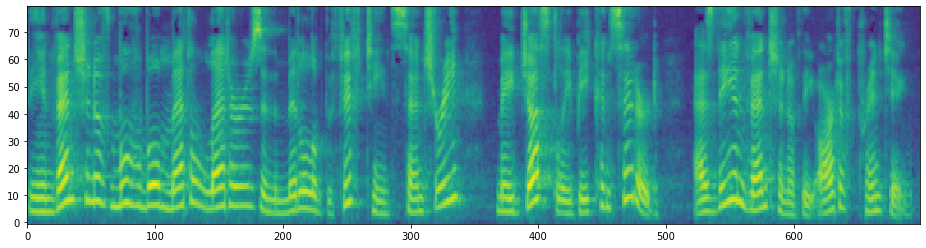

In [7]:
# convert wav to mel spectrogram
stft = TacotronSTFT(filter_length=hp.audio.filter_length,
                    hop_length=hp.audio.hop_length,
                    win_length=hp.audio.win_length,
                    n_mel_channels=hp.audio.n_mel_channels,
                    sampling_rate=hp.audio.sampling_rate,
                    mel_fmin=hp.audio.mel_fmin,
                    mel_fmax=hp.audio.mel_fmax)

sr, wav = read_wav_np("./assets/LJ001-0005.wav")
wav = torch.from_numpy(wav).unsqueeze(0)
mel = stft.mel_spectrogram(wav)
mel = mel.cuda()

# plot
plot_data([mel.data.cpu().numpy()[0]])

In [8]:
#original audio
ipd.Audio(wav, rate=sr) 

In [9]:
mel.data.cpu().numpy()

array([[[-9.183542 , -6.471921 , -6.0836596, ..., -7.4547687,
         -7.713784 , -7.3675704],
        [-6.728715 , -6.1698713, -6.1468263, ..., -6.8449936,
         -7.299059 , -6.998587 ],
        [-5.8362985, -5.4046245, -5.2812576, ..., -6.307955 ,
         -6.4373446, -6.132001 ],
        ...,
        [-6.1043787, -5.9024444, -5.305086 , ..., -9.364645 ,
         -9.534748 , -9.883289 ],
        [-5.605703 , -5.5987206, -5.1356106, ..., -9.202437 ,
         -9.368217 , -9.821229 ],
        [-7.678957 , -7.2099233, -5.6514025, ..., -9.526529 ,
         -9.35383  , -9.967332 ]]], dtype=float32)

In [10]:
mel.data.cpu().numpy().shape
# mel.data.cpu().numpy()[0]

(1, 80, 699)

In [11]:
# inference
audio = model.inference(mel)
audio = audio.cpu().detach().numpy()
# display audio
ipd.Audio(audio, rate=hp.audio.sampling_rate) 

In [12]:
audio

array([-55, -36, -21, ...,  14,  13,   6], dtype=int16)

In [13]:
data_path = "LJSpeech-1.1/wavs/"

stft = TacotronSTFT(filter_length=hp.audio.filter_length,
                        hop_length=hp.audio.hop_length,
                        win_length=hp.audio.win_length,
                        n_mel_channels=hp.audio.n_mel_channels,
                        sampling_rate=hp.audio.sampling_rate,
                        mel_fmin=hp.audio.mel_fmin,
                        mel_fmax=hp.audio.mel_fmax)

wav_files = glob.glob(os.path.join(data_path, '**', '*.wav'), recursive=True)

for wavpath in tqdm.tqdm(wav_files, desc='preprocess wav to mel'):
    sr, wav = read_wav_np(wavpath)
    assert sr == hp.audio.sampling_rate, \
        "sample rate mismatch. expected %d, got %d at %s" % \
        (hp.audio.sampling_rate, sr, wavpath)
    
    if len(wav) < hp.audio.segment_length + hp.audio.pad_short:
        wav = np.pad(wav, (0, hp.audio.segment_length + hp.audio.pad_short - len(wav)), \
                mode='constant', constant_values=0.0)

    wav = torch.from_numpy(wav).unsqueeze(0)
    mel = stft.mel_spectrogram(wav)

    melpath = wavpath.replace('.wav', '.mel')
    torch.save(mel, melpath)

preprocess wav to mel:  16%|█▋        | 2136/13100 [00:21<01:45, 104.12it/s]/content/Introduction-to-GAN/4 - Applications of GANs/melgan/utils/utils.py:12: WavFileWarning: Reached EOF prematurely; finished at 160768 bytes, expected 358246 bytes from header.
  sr, wav = read(path)
preprocess wav to mel: 100%|██████████| 13100/13100 [02:25<00:00, 90.25it/s]


# Text to Speech - Model
-------
![generator](https://assets-global.website-files.com/5d761d627a6dfa90c328ab17/5db9f73df483c66ea419d395_melgan_blogpost_gen.png)

![discriminator](https://assets-global.website-files.com/5d761d627a6dfa90c328ab17/5db9f8ba452fd3351fc1731d_melgan_blogpost_dis.png)



### Generator

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from model.res_stack import ResStack

MAX_WAV_VALUE = 32768.0

In [15]:
# class PrintLayer(nn.Module):
#     def __init__(self):
#         super(PrintLayer, self).__init__()
    
#     def forward(self, x):
#         # Do your print / debug stuff here
#         print(x.shape)
#         return x
    
class Generator(nn.Module):
    def __init__(self, mel_channel):
        super(Generator, self).__init__()
        self.mel_channel = mel_channel

        self.generator = nn.Sequential(
            nn.utils.weight_norm(nn.Conv1d(mel_channel, 512, kernel_size=7, stride=1, padding=3)),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(512, 256, kernel_size=16, stride=8, padding=4)),

            ResStack(256),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(256, 128, kernel_size=16, stride=8, padding=4)),

            ResStack(128),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)),

            ResStack(64),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)),

            ResStack(32),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.Conv1d(32, 1, kernel_size=7, stride=1, padding=3)),
            nn.Tanh(),
        )

    def forward(self, mel):
        mel = (mel + 5.0) / 5.0 # roughly normalize spectrogram
        return self.generator(mel)

    def eval(self, inference=False):
        super(Generator, self).eval()

        # don't remove weight norm while validation in training loop
        if inference:
            self.remove_weight_norm()

    def remove_weight_norm(self):
        for idx, layer in enumerate(self.generator):
            if len(layer.state_dict()) != 0:
                try:
                    nn.utils.remove_weight_norm(layer)
                except:
                    layer.remove_weight_norm()

    def inference(self, mel):
        hop_length = 256
        # pad input mel with zeros to cut artifact
        # see https://github.com/seungwonpark/melgan/issues/8
        zero = torch.full((1, self.mel_channel, 10), -11.5129).to(mel.device)
        mel = torch.cat((mel, zero), dim=2)

        audio = self.forward(mel)
        audio = audio.squeeze() # collapse all dimension except time axis
        audio = audio[:-(hop_length*10)]
        audio = MAX_WAV_VALUE * audio
        audio = audio.clamp(min=-MAX_WAV_VALUE, max=MAX_WAV_VALUE-1)
        audio = audio.short()

        return audio

In [16]:
a = torch.randn(32, 80, 600)  
m = nn.Conv1d(80, 100, kernel_size=16, stride=8, padding=43) 
out = m(a)
print(out.size())
print(m)

torch.Size([32, 100, 84])
Conv1d(80, 100, kernel_size=(16,), stride=(8,), padding=(43,))


In [17]:
from torch.autograd import Variable
x = Variable(torch.randn(1, 80, 600)).cuda()
model_g = Generator(hp.audio.n_mel_channels).cuda()
model_g(x)

tensor([[[-0.0910, -0.1454, -0.1214,  ..., -0.1229, -0.0862, -0.0667]]],
       device='cuda:0', grad_fn=<TanhBackward>)

### Discriminator

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from model.identity import Identity

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.ModuleList([
            nn.Sequential(
                nn.utils.weight_norm(nn.Conv1d(1, 16, kernel_size=15, stride=1, padding=7)),
                nn.LeakyReLU(),
            ),
            nn.Sequential(
                nn.utils.weight_norm(nn.Conv1d(16, 64, kernel_size=41, stride=4, padding=20, groups=4)),
                nn.LeakyReLU(),
            ),
            nn.Sequential(
                nn.utils.weight_norm(nn.Conv1d(64, 256, kernel_size=41, stride=4, padding=20, groups=16)),
                nn.LeakyReLU(),
            ),
            nn.Sequential(
                nn.utils.weight_norm(nn.Conv1d(256, 1024, kernel_size=41, stride=4, padding=20, groups=64)),
                nn.LeakyReLU(),
            ),
            nn.Sequential(
                nn.utils.weight_norm(nn.Conv1d(1024, 1024, kernel_size=41, stride=4, padding=20, groups=256)),
                nn.LeakyReLU(),
            ),
            nn.Sequential(
                nn.utils.weight_norm(nn.Conv1d(1024, 1024, kernel_size=5, stride=1, padding=2)),
                nn.LeakyReLU(),
            ),
            nn.utils.weight_norm(nn.Conv1d(1024, 1, kernel_size=3, stride=1, padding=1)),
        ])

    def forward(self, x):
        '''
            returns: (list of 6 features, discriminator score)
            we directly predict score without last sigmoid function
            since we're using Least Squares GAN (https://arxiv.org/abs/1611.04076)
        '''
        features = list()
        for module in self.discriminator:
            x = module(x)
            features.append(x)
        return features[:-1], features[-1]

In [20]:
class MultiScaleDiscriminator(nn.Module):
    def __init__(self):
        super(MultiScaleDiscriminator, self).__init__()

        self.discriminators = nn.ModuleList(
            [Discriminator() for _ in range(3)]
        )
        
        self.pooling = nn.ModuleList(
            [Identity()] +
            [nn.AvgPool1d(kernel_size=4, stride=2, padding=2) for _ in range(1, 3)]
        )

    def forward(self, x):
        ret = list()

        for pool, disc in zip(self.pooling, self.discriminators):
            x = pool(x)
            ret.append(disc(x))

        return ret # [(feat, score), (feat, score), (feat, score)]

# Text to Speech - Training

In [21]:
import os
import math
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import traceback

from utils.utils import get_commit_hash
from utils.validation import validate
from datasets.dataloader import create_dataloader

import logging
import time

with open("./config/default.yaml", 'r') as f:
        hp_str = ''.join(f.readlines())

In [22]:
model_g = Generator(hp.audio.n_mel_channels).cuda()
model_d = MultiScaleDiscriminator().cuda()

optim_g = torch.optim.Adam(model_g.parameters(),
                           lr=hp.train.adam.lr, betas=(hp.train.adam.beta1, hp.train.adam.beta2))
optim_d = torch.optim.Adam(model_d.parameters(),
                           lr=hp.train.adam.lr, betas=(hp.train.adam.beta1, hp.train.adam.beta2))

model_g.train()
model_d.train()

MultiScaleDiscriminator(
  (discriminators): ModuleList(
    (0): Discriminator(
      (discriminator): ModuleList(
        (0): Sequential(
          (0): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): Sequential(
          (0): Conv1d(16, 64, kernel_size=(41,), stride=(4,), padding=(20,), groups=4)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (2): Sequential(
          (0): Conv1d(64, 256, kernel_size=(41,), stride=(4,), padding=(20,), groups=16)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (3): Sequential(
          (0): Conv1d(256, 1024, kernel_size=(41,), stride=(4,), padding=(20,), groups=64)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (4): Sequential(
          (0): Conv1d(1024, 1024, kernel_size=(41,), stride=(4,), padding=(20,), groups=256)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (5): Sequential(
          (0): Conv

In [23]:
trainloader = create_dataloader(hp, None, True)
valloader = create_dataloader(hp, None, False)

In [24]:
githash = get_commit_hash()

In [25]:
name = 'melgan_demo'
pt_dir = os.path.join(hp.log.chkpt_dir, name)
log_dir = os.path.join(hp.log.log_dir, name)
os.makedirs(pt_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [26]:
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(os.path.join(log_dir,
                '%s-%d.log' % (name, time.time()))),
            logging.StreamHandler()
        ]
    )
logger = logging.getLogger()

In [ ]:
init_epoch = -1
step = 0

for epoch in itertools.count(init_epoch+1):
  # if epoch % hp.log.validation_interval == 0:
  #     with torch.no_grad():
  #         validate(hp, args, model_g, model_d, valloader, writer, step)

  trainloader.dataset.shuffle_mapping()
  loader = tqdm.tqdm(trainloader, desc='Loading train data')
  for (melG, audioG), (melD, audioD) in loader:
      melG = melG.cuda()
      audioG = audioG.cuda()
      melD = melD.cuda()
      audioD = audioD.cuda()

      # generator
      optim_g.zero_grad()
      fake_audio = model_g(melG)[:, :, :hp.audio.segment_length]
      disc_fake = model_d(fake_audio)
      disc_real = model_d(audioG)
      loss_g = 0.0
      for (feats_fake, score_fake), (feats_real, _) in zip(disc_fake, disc_real):
          loss_g += torch.mean(torch.sum(torch.pow(score_fake - 1.0, 2), dim=[1, 2]))
          for feat_f, feat_r in zip(feats_fake, feats_real):
              loss_g += hp.model.feat_match * torch.mean(torch.abs(feat_f - feat_r))

      loss_g.backward()
      optim_g.step()

      # discriminator
      fake_audio = model_g(melD)[:, :, :hp.audio.segment_length]
      fake_audio = fake_audio.detach()
      loss_d_sum = 0.0
      for _ in range(hp.train.rep_discriminator):
          optim_d.zero_grad()
          disc_fake = model_d(fake_audio)
          disc_real = model_d(audioD)
          loss_d = 0.0
          for (_, score_fake), (_, score_real) in zip(disc_fake, disc_real):
              loss_d += torch.mean(torch.sum(torch.pow(score_real - 1.0, 2), dim=[1, 2]))
              loss_d += torch.mean(torch.sum(torch.pow(score_fake, 2), dim=[1, 2]))

          loss_d.backward()
          optim_d.step()
          loss_d_sum += loss_d

      step += 1
      # logging
      loss_g = loss_g.item()
      loss_d_avg = loss_d_sum / hp.train.rep_discriminator
      loss_d_avg = loss_d_avg.item()
      if any([loss_g > 1e8, math.isnan(loss_g), loss_d_avg > 1e8, math.isnan(loss_d_avg)]):
          logger.error("loss_g %.01f loss_d_avg %.01f at step %d!" % (loss_g, loss_d_avg, step))
          raise Exception("Loss exploded")


  if epoch % hp.log.save_interval == 0:
      save_path = os.path.join(pt_dir, '%s_%s_%04d.pt'
          % (name, githash, epoch))
      torch.save({
          'model_g': model_g.state_dict(),
          'model_d': model_d.state_dict(),
          'optim_g': optim_g.state_dict(),
          'optim_d': optim_d.state_dict(),
          'step': step,
          'epoch': epoch,
          'hp_str': hp_str,
          'githash': githash,
      }, save_path)
      logger.info("Saved checkpoint to: %s" % save_path)
